##### Figure 8
# Map of 10-m HRRR winds and MesoWest winds

In [1]:
%matplotlib inline
import h5py
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
from mpl_toolkits.basemap import Basemap

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2')
from BB_downloads.HRRR_S3 import *
from BB_wx_calcs.wind import wind_uv_to_spd
from BB_basemap.draw_maps import draw_CONUS_HRRR_map
from BB_MesoWest.MesoWest_STNinfo import get_MW_location_dict
from BB_MesoWest.MesoWest_timeseries import get_mesowest_ts
from BB_MesoWest.MesoWest_nearesttime import get_mesowest_nearesttime
from BB_MesoWest.MesoWest_percentiles import get_mesowest_percentiles
from BB_data.grid_manager import pluck_point_new
from BB_wx_calcs.wind import wind_uv_to_spd

In [194]:
from matplotlib.dates import DateFormatter
formatter = DateFormatter('%b')

import matplotlib as mpl 
two_column = 5.5
one_column = 3.2
twothird_column = 6.8
mpl.rcParams['figure.figsize'] = [twothird_column, twothird_column+5]
mpl.rcParams['figure.titlesize'] = 12
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['figure.subplot.wspace'] = 0.03
mpl.rcParams['figure.subplot.hspace'] = 0.05
mpl.rcParams['legend.fontsize'] = 7
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
    
mpl.rcParams['savefig.dpi'] = 1000    # 600 for print

AMS Journal Figure size chart.  
_Note: Figsize parameter may differ from what is actually generated_

| One Colulmn | 2/3 Page   | Two Columns   | More than 2 columns  |
|---|---|---|---|
| 3.2   | 4.5  | 5.5  | 6.5  |


---

In [21]:
def get_OSG_point_percentiles(DATE, percentile=50):
    variable = var.replace(':', '_').replace(' ', '_')
    DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/%s/' % (variable)
    FILE = 'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % ((variable, DATE.month, DATE.day, DATE.hour))
    
    with h5py.File(DIR+FILE, 'r') as f:
        per_value = f["p%02d" % percentile][x][y]
    
    # Convert Units
    if var == 'TMP:2 m' or var == 'DPT:2 m':
        per_value -= 273.15
    
    return per_value

In [22]:
def get_OSG_percentiles(DATE, percentile=50):
    variable = var.replace(':', '_').replace(' ', '_')
    DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/%s/' % (variable)
    FILE = 'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % ((variable, DATE.month, DATE.day, DATE.hour))
    
    with h5py.File(DIR+FILE, 'r') as f:
        per_value = f["p%02d" % percentile][:]
    
    # Convert Units
    if var == 'TMP:2 m' or var == 'DPT:2 m':
        per_value -= 273.15
    
    return per_value

---------

In [18]:
# Map Center Location, a MesoWest station ID
stn = 'HWKC1'
var = 'UVGRD:10 m'

In [19]:
if var == 'TMP:2 m':
    MWvar = 'air_temp'
    label = '2 m Temperature'
    units = 'C'
    cmap = 'bwr'
elif var == 'DPT:2 m':
    MWvar = 'dew_point_temperature'
    label = '2 m Dew Point Temperature'
    units = 'C'
    cmap = 'BrBG'
elif var == 'UVGRD:10 m':
    MWvar = 'wind_speed'
    label = '10 m Wind Speed'
    units = r'm s$\mathregular{^{-1}}$'
    cmap = 'PiYG'
elif var == 'UVGRD:80 m':
    MWvar = 'wind_speed'
    label = '80 m Wind Speed'
    units = r'm s$\mathregular{^{-1}}$'
    cmap = 'PRGn'
else:
    MWvar = ''
    label = 'unknown'
    units = 'unknown'
    cmap = 'viridis'
    print "NO MATCHING VAR AND MESOWEST VAR"

In [10]:
# Percentile of interest
p=95

In [232]:
# Get list of stations in the area
from BB_MesoWest.get_token import my_token
import json

token = my_token()
URL = 'http://api.mesowest.net/v2/stations/metadata?&token=' + token + '&radius=HWKC1,45&vars=wind_speed'
if False:
    URL += '&network=1,2'
f = urllib2.urlopen(URL)
data_CA = f.read()
data_CA = json.loads(data_CA)

In [233]:
num = int(len(data_CA['STATION']))
print 'Number of Stations: %.f' % num

Number of Stations: 208


In [234]:
# Create a map centered at the station of interest: HWKC1
for s in data_CA['STATION']:
    if s['STID'] == stn:
        MWlon = float(s['LONGITUDE'])
        MWlat = float(s['LATITUDE'])

# Create Map Object
mapCenterLat = MWlat-.02
mapCenterLon = MWlon+.06
m = Basemap(projection='cyl', resolution='c', area_thresh=1000,
            llcrnrlon=mapCenterLon-.4,  urcrnrlon=mapCenterLon+.4,
            llcrnrlat=mapCenterLat-.4, urcrnrlat=mapCenterLat+.4)

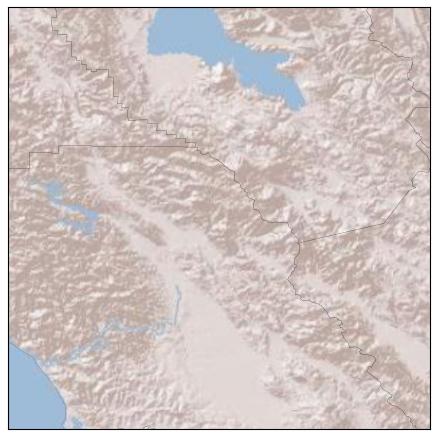

In [230]:
m.drawcounties()
m.arcgisimage(service='World_Shaded_Relief', dpi=1000)

### Retrieve Data

In [243]:
DATE = datetime(2017, 10, 9, 6)

start = DATE.strftime('%m%d%H')
end = start

stns_gt_3yrs = 0

for i, s in enumerate(data_CA['STATION']):
    print '\r>> %.2f%% complete. Working on %s' % (i/float(num)*100, s['STID']),
    sys.stdout.flush()
    
    # MesoWest percentile
    if 'PORTABLE' in s['NAME']:
        print " --> %s is a portable station. Skip it." % s['STID']
        continue
    else:
        try:
            a = get_mesowest_percentiles(s['STID'], variable=MWvar, start=start, end=end, percentiles=[p])
            if a['years'] >= 3:
                stns_gt_3yrs += 1
                MW_per = a['p%02d' % p][0]
                s['MW_per'] = MW_per

                # HRRR percentile
                MWlat = float(s['LATITUDE'])
                MWlon = float(s['LONGITUDE'])
                point = pluck_point_new(MWlat, MWlon, lat, lon)
                x = point[0][0]
                y = point[1][0]
                # save center of plot for later...
                if s['STID'] == 'HWKC1':
                    point = pluck_point_new(MWlat, MWlon, lat, lon)
                    X = point[0][0]
                    Y = point[1][0]
                HR_per = get_OSG_point_percentiles(DATE, percentile=p)
                s['HR_per'] = HR_per
                s['years'] = a['years']
        except:
            pass
print '\r>> Data retrieval 100% complete.',
print "# stations with more than three years:", stns_gt_3yrs

>> 8.65% complete. Working on TR102  --> TR102 is a portable station. Skip it.
>> 9.13% complete. Working on TR110  --> TR110 is a portable station. Skip it.
>> 10.10% complete. Working on TR163  --> TR163 is a portable station. Skip it.
>> 10.58% complete. Working on TR164  --> TR164 is a portable station. Skip it.
>> 11.06% complete. Working on TR417  --> TR417 is a portable station. Skip it.
>> 23.56% complete. Working on TS378  --> TS378 is a portable station. Skip it.
>> 24.04% complete. Working on TS392  --> TS392 is a portable station. Skip it.
>> Data retrieval 100% complete. # stations with more than three years: 110


In [244]:
for s in data_CA['STATION']:
    if 'years' in s:
        print s['years'], s['STID'], s['HR_per']-s['MW_per']

[20] KSTS -1.114
[20] KUKI -0.268
[18] BNVC1 -0.244
[18] BKSC1 0.697
[18] WISC1 2.143
[18] HWKC1 2.07
[18] HGLC1 -0.008
[18] KNXC1 0.877
[18] COWC1 -2.221
[18] RSAC1 -0.552
[16] HPDC1 -1.664
[8] NPYC1 -3.87
[8] TMPC1 -2.407
[16] KELC1 0.524
[5] CQ039 2.359
[11] CQ063 -0.002
[14] C0622 2.879
[14] C0677 1.088
[14] CI077 1.184
[14] CI083 0.439
[13] CI085 2.516
[14] CI103 0.402
[14] CI106 0.965
[14] CI109 0.503
[14] CI144 1.444
[14] CI158 2.672
[13] C1766 2.697
[13] AR323 2.777
[4] PREC1 -0.836
[3] H0237 1.404
[4] H0300 3.312
[4] H0447 0.436
[4] H0452 3.672
[4] H0505 0.951
[12] CQ136 -0.916
[5] CQ156 0.278
[12] C3627 2.243
[12] C3628 1.518
[3] C3724 2.025
[12] AR834 3.333
[12] CI196 1.584
[10] C3931 2.629
[9] C4897 2.085
[8] C5671 2.336
[11] C5786 0.33
[8] CQ176 -1.619
[11] 46013 -1.531
[4] C6576 0.305
[11] PTRCA -1.912
[7] C6940 1.786
[10] AS725 2.187
[9] KDVO 0.917
[9] KHES 1.756
[9] AT068 1.64
[7] D1660 2.486
[9] D1970 2.586
[8] D2144 3.301
[8] D2695 1.301
[8] D2849 4.022
[8] D3481 3.02

### Plot data

In [245]:
add_cities = False
add_fireperim = True

5.857 -3.87
2017-10-09 06:00:00
HRRR 95th - MesoWest 95th


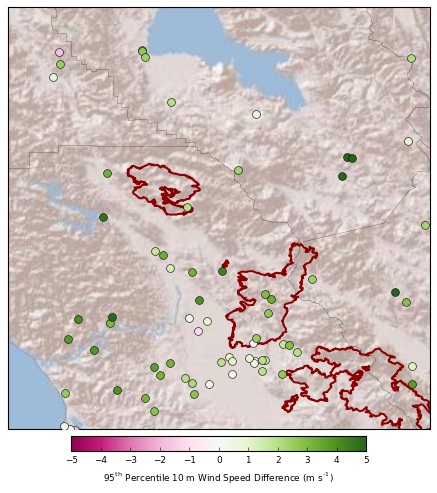

In [246]:
# plot difference
m.arcgisimage(service='World_Shaded_Relief', dpi=100)
m.drawstates()
m.drawcounties()
max_diff = 0
min_diff = 0
for s in data_CA['STATION']:
    if 'years' in s and s['years'] >= 3:
        m.scatter(float(s['LONGITUDE']), float(s['LATITUDE']),
                  latlon=True,
                  c=s['HR_per']-s['MW_per'],
                  linewidth=.5,
                  edgecolor='k',
                  s=50,
                  cmap='PiYG',
                  vmin=-5, vmax=5,
                  zorder=10)
        if s['HR_per']-s['MW_per'] > max_diff:
            max_diff = s['HR_per']-s['MW_per']
        if s['HR_per']-s['MW_per'] < min_diff:
            min_diff = s['HR_per']-s['MW_per']

cb = plt.colorbar(orientation='horizontal', pad=.01, shrink=.7)
cb.set_label(r'%s$\mathregular{^{th}}$ ' % p + 'Percentile %s Difference (%s)' % (label, units))
cb.set_ticks([range(-5,6)])

#plt.title(r'%s$\mathregular{^{th}}$' % p + 'Percentile Difference\n', fontweight='semibold', fontsize=15)
#plt.title(DATE.strftime('%d %B'), fontweight='semibold', loc='left')
#plt.title(DATE.strftime('%H:%M UTC'), fontweight='semibold', loc='right')
#plt.xlabel(r'HRRR %s$\mathregular{^{th}}$ - MesoWest %s$\mathregular{^{th}}$' % (p,p))

if add_cities:
    cities = {'Geyserville': (38.700078, -122.883772),
              'Santa Rosa': (38.452214, -122.717661),
              'Healdsburg': (38.606396, -122.869722),
              'Cloverdale': (38.794959, -123.006450),
              'Middletown': (38.750411, -122.615162),
              'Clearlake': (38.950727, -122.620816),
              'Calistoga': (38.580932, -122.580472)}

    import matplotlib.patheffects as path_effects
    for c in cities:
        text = plt.text(cities[c][1], cities[c][0], c,
                        color='white', ha='center', va='center')
        text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                               path_effects.Normal()])


if add_fireperim:
    pocket = '/uufs/chpc.utah.edu/common/home/u0553130/oper/HRRR_fires/fire_shapefiles/2017_pocket/ca_pocket_20171025_2130_dd83'
    m.readshapefile(pocket, 'pocket', drawbounds=False)
    
    tubbs = '/uufs/chpc.utah.edu/common/home/u0553130/oper/HRRR_fires/fire_shapefiles/2017_tubbs/ca_tubbs_20171025_2130_dd83'
    m.readshapefile(tubbs, 'tubbs', drawbounds=False)
    
    nuns = '/uufs/chpc.utah.edu/common/home/u0553130/oper/HRRR_fires/fire_shapefiles/2017_nuns/ca_nuns_20171025_2130_dd83'
    m.readshapefile(nuns, 'nuns', drawbounds=False)

    for info, shape in zip(m.pocket, m.pocket):
        fire_x, fir_y = zip(*shape) 
        m.plot(fire_x, fir_y, marker=None, color='darkred')
    for info, shape in zip(m.tubbs, m.tubbs):
        fire_x, fir_y = zip(*shape) 
        m.plot(fire_x, fir_y, marker=None, color='darkred')
    for info, shape in zip(m.nuns, m.nuns):
        fire_x, fir_y = zip(*shape) 
        m.plot(fire_x, fir_y, marker=None, color='darkred')
plt.savefig('./figs/Fig_08_95th_HRRR_MW_difference')

print max_diff, min_diff
print DATE
print 'HRRR 95th - MesoWest 95th'

In [251]:
# Get HRRR 95th percentile for the valid date
p95 = get_OSG_percentiles(DATE, percentile=95)

In [252]:
# HRRR at time of interest
fxx = 12
RUNDATE = DATE-timedelta(hours=fxx)
Hu = get_hrrr_variable(RUNDATE, 'UGRD:10 m', fxx=fxx, verbose=False)
Hv = get_hrrr_variable(RUNDATE, 'VGRD:10 m', fxx=fxx, verbose=False)
H = Hu.copy()
H['value'] = wind_uv_to_spd(Hu['value'], Hv['value'])

print 'Valid:\t\t%s\nInitalized:\t%s' % (Hu['valid'].strftime('%Y-%m-%d %H:%M'), Hu['anlys'].strftime('%Y-%m-%d %H:%M'))

Valid:		2017-10-09 06:00
Initalized:	2017-10-08 18:00


09 October 2017 06:00 UTC --- F12


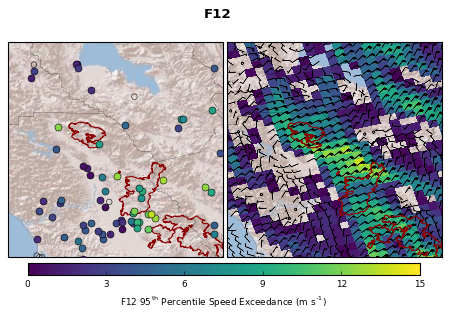

In [254]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[7,3.8])

cmap = 'viridis'

add_fireperim = True

# HRRR forecast - Observation 95th Percenitle
plt.sca(ax1)
m.arcgisimage(service='World_Shaded_Relief', dpi=1000)
m.drawcounties()

for s in data_CA['STATION']:
    if 'years' in s and s['years'] >= 3:
        # Pluck the HRRR forecast value for the nearest point
        MWlat = float(s['LATITUDE'])
        MWlon = float(s['LONGITUDE'])
        point = pluck_point_new(MWlat, MWlon, lat, lon)
        x = point[0][0]
        y = point[1][0]
        Hpoint = H['value'][x][y]

        # Plot stations where HRRR analysis is greater than station 95th, else plot an empty marker
        if Hpoint-s['MW_per'] > 0:
            m.scatter(MWlon, MWlat,
                      c=Hpoint-s['MW_per'],
                      latlon=True,
                      linewidth=.5,
                      edgecolor='k',
                      s=40,
                      cmap=cmap,
                      vmin=0, vmax=15,
                      zorder=10)
        else:
            m.scatter(MWlon, MWlat,
                      latlon=True,
                      facecolors='none',
                      edgecolors='k',
                      linewidth=.5,
                      s=25,
                      zorder=10)

plt.suptitle('F%02d' % fxx)
#plt.title(DATE.strftime('%d %B 2017'), fontweight='semibold', loc='left')
#plt.title(DATE.strftime('%H:%M UTC'), fontweight='semibold', loc='right')
#plt.xlabel(r'HRRR F%02d - MesoWest %s$\mathregular{^{th}}$' % (fxx,p))


if add_fireperim:
    pocket = '/uufs/chpc.utah.edu/common/home/u0553130/oper/HRRR_fires/fire_shapefiles/2017_pocket/ca_pocket_20171025_2130_dd83'
    m.readshapefile(pocket, 'pocket', drawbounds=False)
    
    tubbs = '/uufs/chpc.utah.edu/common/home/u0553130/oper/HRRR_fires/fire_shapefiles/2017_tubbs/ca_tubbs_20171025_2130_dd83'
    m.readshapefile(tubbs, 'tubbs', drawbounds=False)
    
    nuns = '/uufs/chpc.utah.edu/common/home/u0553130/oper/HRRR_fires/fire_shapefiles/2017_nuns/ca_nuns_20171025_2130_dd83'
    m.readshapefile(nuns, 'nuns', drawbounds=False)

    for info, shape in zip(m.pocket, m.pocket):
        fire_x, fir_y = zip(*shape) 
        m.plot(fire_x, fir_y, marker=None, color='darkred', linewidth=1)
    for info, shape in zip(m.tubbs, m.tubbs):
        fire_x, fir_y = zip(*shape) 
        m.plot(fire_x, fir_y, marker=None, color='darkred', linewidth=1)
    for info, shape in zip(m.nuns, m.nuns):
        fire_x, fir_y = zip(*shape) 
        m.plot(fire_x, fir_y, marker=None, color='darkred', linewidth=1)

plt.sca(ax2)
# plot difference
m.arcgisimage(service='World_Shaded_Relief', dpi=1000)
m.drawcounties()


masked = H['value']-p95
masked = np.ma.array(masked)
masked[masked < 0] = np.ma.masked


pcm = m.pcolormesh(lon, lat, masked,
                   vmax=15, vmin=0,
                   cmap=cmap)

# Wind barbs
# Cut box for plotting barbs
bfr=30
thin=1
Cgridlat = lat[X-bfr:X+bfr, Y-bfr:Y+bfr]
Cgridlon = lon[X-bfr:X+bfr, Y-bfr:Y+bfr]
CHu = Hu['value'][X-bfr:X+bfr, Y-bfr:Y+bfr]
CHv = Hv['value'][X-bfr:X+bfr, Y-bfr:Y+bfr]
m.barbs(Cgridlon[::thin,::thin], Cgridlat[::thin,::thin],
        CHu[::thin,::thin], CHv[::thin,::thin],
        zorder=2, length=3.7, linewidth=.45,
        barb_increments={'half':2.5, 'full':5,'flag':25},
        latlon=True)

#plt.title(DATE.strftime('%d %B 2017'), fontweight='semibold', loc='left')
#plt.title(DATE.strftime('%H:%M UTC'), fontweight='semibold', loc='right')
#plt.xlabel(r'HRRR F%02d - HRRR %s$\mathregular{^{th}}$' % (fxx, p))

if add_fireperim:
    pocket = '/uufs/chpc.utah.edu/common/home/u0553130/oper/HRRR_fires/fire_shapefiles/2017_pocket/ca_pocket_20171025_2130_dd83'
    m.readshapefile(pocket, 'pocket', drawbounds=False)
    
    tubbs = '/uufs/chpc.utah.edu/common/home/u0553130/oper/HRRR_fires/fire_shapefiles/2017_tubbs/ca_tubbs_20171025_2130_dd83'
    m.readshapefile(tubbs, 'tubbs', drawbounds=False)
    
    nuns = '/uufs/chpc.utah.edu/common/home/u0553130/oper/HRRR_fires/fire_shapefiles/2017_nuns/ca_nuns_20171025_2130_dd83'
    m.readshapefile(nuns, 'nuns', drawbounds=False)

    for info, shape in zip(m.pocket, m.pocket):
        fire_x, fir_y = zip(*shape) 
        m.plot(fire_x, fir_y, marker=None, color='darkred', linewidth=1, zorder=5)
    for info, shape in zip(m.tubbs, m.tubbs):
        fire_x, fir_y = zip(*shape) 
        m.plot(fire_x, fir_y, marker=None, color='darkred', linewidth=1, zorder=5)
    for info, shape in zip(m.nuns, m.nuns):
        fire_x, fir_y = zip(*shape) 
        m.plot(fire_x, fir_y, marker=None, color='darkred', linewidth=1, zorder=5)
        
fig.subplots_adjust(hspace=0, wspace=0.02)
cbar_ax = fig.add_axes([0.16, 0.1, 0.7, 0.04]) # [left, bottom, width, height]
cb = fig.colorbar(pcm, cax=cbar_ax, ticks=range(0,16,3), orientation='horizontal')
cb.ax.set_xlabel(r'F%02d 95$\mathregular{^{th}}$ Percentile Speed Exceedance (%s)' % (fxx, units))

plt.savefig('./figs/Fig_08_95th_wind_map_f%02d' % fxx)

print DATE.strftime('%d %B 2017 %H:%M UTC --- F'+'%02d'%fxx)